In [1]:
# Let's import needed libraries
import albumentations as A
import cv2
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from skimage.color import label2rgb
%matplotlib inline

In [2]:
#Set image size
IMG_SIZE = 512
MAX_SIZE = 1120
IMAGE_ID = '0461935888bad18244f11e67e7d3b417.jpg'

In [10]:
#Set the path to the data
input_path = 'Data Sources'
image_filepath = os.path.join(input_path,IMAGE_ID)
annot_filepath = os.path.join(input_path,'annotations.csv')

In [12]:
#Let's load an image with annotations
image = cv2.imread(image_filepath, cv2.IMREAD_UNCHANGED) 
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # I am still wondering why OpenCV changed to BGR by default
height, width, channels = image.shape
height, width

(1685, 1123)

In [13]:
# load annotations
anns = pd.read_csv(annot_filepath)
anns.head()

,Unnamed: 0,ImageId,EncodedPixels,Height,Width,ClassId
0,5842,0461935888bad18244f11e67e7d3b417.jpg,557478 5 559160 13 560842 19 562524 23 564207 ...,1685,1123,23
1,5843,0461935888bad18244f11e67e7d3b417.jpg,980274 1 981958 4 983642 7 985326 10 987011 13...,1685,1123,23
2,5844,0461935888bad18244f11e67e7d3b417.jpg,599196 20 600864 51 602533 68 604201 87 605872...,1685,1123,6
3,5845,0461935888bad18244f11e67e7d3b417.jpg,934184 28 935869 63 937554 82 939239 83 940924...,1685,1123,32
4,5846,0461935888bad18244f11e67e7d3b417.jpg,841509 5 843193 7 844878 8 846562 10 848247 9 ...,1685,1123,42


In [14]:
def img_masks_targets(df, img_id):
    """Select all targets of one image as an array of numbers
       Select all masks of one image as an array of RLE strings
       Output: 
            masks and targets for an image
    """
    # select all targets of one image as an array of numbers
    targets = df[df['ImageId'] == img_id]["ClassId"].values
    # select all masks of one image as an array is strings
    rles = df[df['ImageId'] == img_id]["EncodedPixels"].values
    return targets, rles

In [15]:
labels, rles = img_masks_targets(anns, img_id = IMAGE_ID)
num_instances = len(rles)
print(f'Number of instances on the image {len(rles)}')

Number of instances on the image 10


Masks for the image often come in the run-length encoded format (RLE). We need to convert them to binary masks to plot and/or augment. Here are some helpers for RLE encoding and decoding taken from here: https://www.kaggle.com/paulorzp/run-length-encode-and-decode

In [16]:
def rle_decode(rle_str: str, mask_shape: tuple, mask_dtype=np.uint8):
    """Helper to decode RLE string to a binary mask"""
    s = rle_str.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    mask = np.zeros(np.prod(mask_shape), dtype=mask_dtype)
    for lo, hi in zip(starts, ends):
        mask[lo:hi] = 1
    return mask.reshape(mask_shape[::-1]).T


def rle_encode(mask):
    """Helper to encode binary mask to RLE string"""
    pixels = mask.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    rle = np.where(pixels[1:] != pixels[:-1])[0] + 1
    rle[1::2] -= rle[::2]
    return rle.tolist()

In [17]:
masks = np.zeros((len(rles), height, width), dtype = np.uint8)
for num in range(num_instances):
    masks[num, :, :] = rle_decode(rles[num], (height, width), np.uint8)

print(masks.shape) 

(10, 1685, 1123)


Define some helper functions to visualize data and labels

In [18]:
def visualize_bbox(img, bbox, color=(255, 255, 0), thickness=2):  
    """Helper to add bboxes to images 
    Args:
        img : image as open-cv numpy array
        bbox : boxes as a list or numpy array in pascal_voc fromat [x_min, y_min, x_max, y_max]  
        color=(255, 255, 0): boxes color 
        thickness=2 : boxes line thickness
    """
    x_min, y_min, x_max, y_max = bbox
    x_min, y_min, x_max, y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    return img


def plot_image_anns(image, masks, boxes=None):
    """Helper to plot images with bboxes and masks 
    Args:
        image: image as open-cv numpy array, original and augmented
        masks: setof binary masks, original and augmented 
        bbox : boxes as a list or numpy array, original and augmented       
    """
    # glue binary masks together
    one_mask = np.zeros_like(masks[0])
    for i, mask in enumerate(masks):
        one_mask += (mask > 0).astype(np.uint8) * (11-i) # (11-i) so my inner artist is happy with the masks colors     
      
    if boxes is not None:
        for box in boxes:
            image = visualize_bbox(image, box)
            
    # for binary masks we get one channel and need to convert to RGB for visualization
    mask_rgb = label2rgb(one_mask, bg_label=0)            
        
    f, ax = plt.subplots(1, 2, figsize=(16, 16))             
    ax[0].imshow(image)
    ax[0].set_title('Original image')     
    ax[1].imshow(mask_rgb, interpolation='nearest')
    ax[1].set_title('Original mask')
    f.tight_layout()
    plt.show() 


def plot_image_aug(image, image_aug, masks, aug_masks, boxes, aug_boxes):
    """Helper to plot images with bboxes and masks and their augmented versions 
    Args:
        image, image_aug: image as open-cv numpy array, original and augmented
        masks, aug_masks:setof binary masks, original and augmented 
        bbox, aug_boxes : boxes as a list or numpy array, original and augmented       
    """
    # glue masks together
    one_mask = np.zeros_like(masks[0])
    for i, mask in enumerate(masks):
        one_mask += (mask > 0).astype(np.uint8) * (11-i)       
    
    one_aug_mask = np.zeros_like(aug_masks[0])
    for i, augmask in enumerate(aug_masks):
        one_aug_mask += (augmask > 0).astype(np.uint8) * (11-i) 
    
    for box in boxes:
        image = visualize_bbox(image, box)
    for augbox in aug_boxes:
        image_aug = visualize_bbox(image_aug, augbox)    
        
    # for binary masks we get one channel and need to convert to RGB for visualization
    mask_rgb = label2rgb(one_mask, bg_label=0)            
    mask_aug_rgb = label2rgb(one_aug_mask, bg_label=0) 
    
    f, ax = plt.subplots(2, 2, figsize=(16, 16))             
    ax[0, 0].imshow(img)
    ax[0, 0].set_title('Original image')        
    ax[0, 1].imshow(image_aug)
    ax[0, 1].set_title('Augmented image')     
    ax[1, 0].imshow(mask_rgb, interpolation='nearest')
    ax[1, 0].set_title('Original mask')
    ax[1, 1].imshow(mask_aug_rgb, interpolation='nearest')
    ax[1, 1].set_title('Augmented mask')
    f.tight_layout()
    plt.show() 

Let's look at our image and corresponding masks

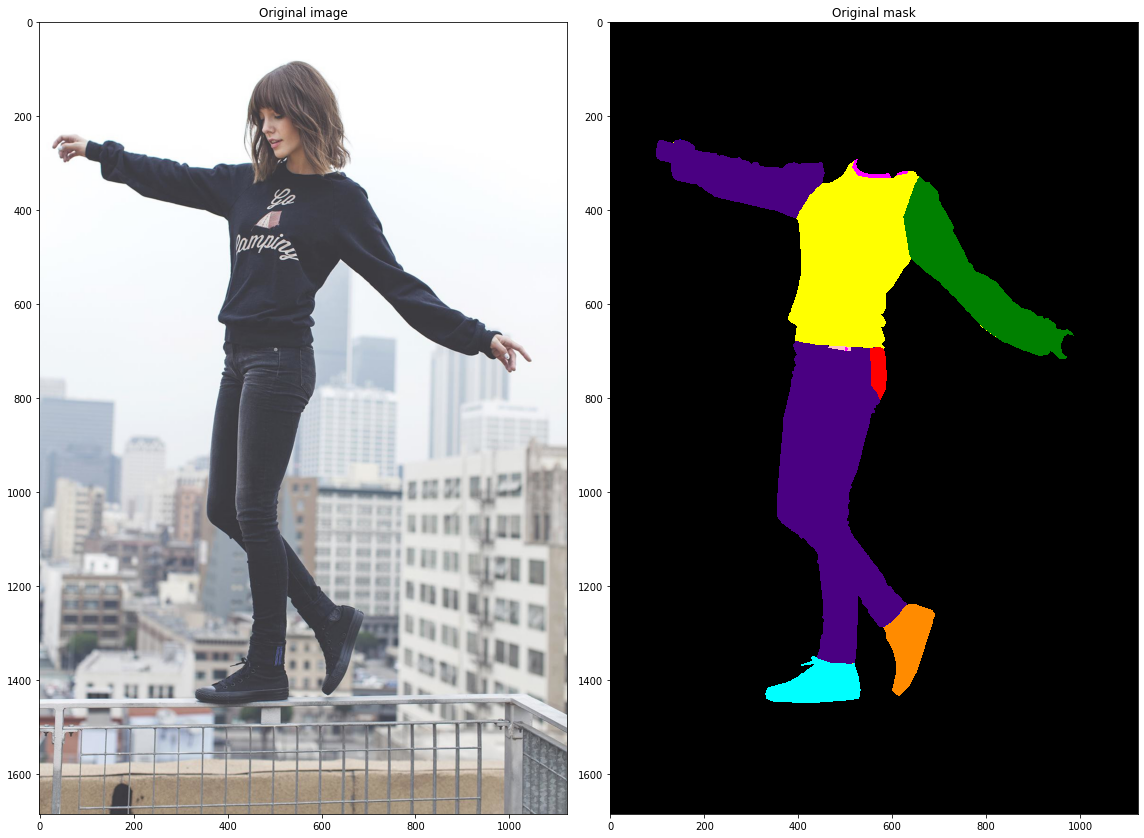

In [20]:
plot_image_anns(image, masks)

Now let's create a list of transforms we want to apply for an image and annotations.

The choice of augmentations depends on your task. The common sets include:

* D4 symmetry group augmentations for satellite imaging data; 

* crops, rotation and scales with varying brightness and colors for classification; 

* weather comditions simulation for camera-based self-driving tasks; 

* noise, blur and mild rotations for X-Ray chest scans, and so on.

Here we will make some lists for experimenting. In practice, it's better to create transforms.py file and put it all there.

Please note: A.Normalize function -- normalizes image as in ImageNet dataset training. It's recommended to do it before sending data to your model, especially if you use pretrained on ImageNet backbone. Here I commented it for the visualization puproses (so that colors look right, my inner artist again :))

In [21]:
D4_transforms = [A.Resize(height//2, width//2, interpolation=cv2.INTER_LINEAR, p=1), 
                # D4 Group augmentations
                A.HorizontalFlip(p=1),
                A.VerticalFlip(p=0.5),
                A.RandomRotate90(p=0.5),
                A.Transpose(p=0.5),                   
                #A.Normalize()
                ]

geom_transforms =  [A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=15, 
                       interpolation=cv2.INTER_LINEAR, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=0.5),
                    # D4 Group augmentations
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                    A.RandomRotate90(p=0.5),
                    A.Transpose(p=0.5),
                    # crop and resize  
                    A.RandomSizedCrop((MAX_SIZE-100, MAX_SIZE), height//2, width//2, w2h_ratio=1.0, 
                                        interpolation=cv2.INTER_LINEAR, always_apply=False, p=0.5),  
                    A.Resize(height//2, width//2, interpolation=cv2.INTER_LINEAR, p=1), 
                    #A.Normalize(),
                    ]
                 
heavy_transforms = [A.RandomRotate90(),
                    A.Flip(),
                    A.Transpose(),
                    A.GaussNoise(),
                    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.7),                    
                    A.OneOf([
                        A.MotionBlur(p=0.2),
                        A.MedianBlur(blur_limit=3, p=0.1),
                        A.Blur(blur_limit=3, p=0.1),
                    ], p=0.5),                    
                    A.OneOf([                        
                        A.IAASharpen(),
                        A.IAAEmboss(),
                        A.RandomBrightnessContrast(),
                    ], p=0.5),
                    A.HueSaturationValue(p=0.3),
                    #A.Normalize(),
                    ]

RuntimeError: You are trying to use a deprecated augmentation 'IAASharpen' which depends on the imgaug library, but imgaug is not installed.

There are two options to fix this error:
1. [Recommended]. Switch to the Albumentations' implementation of the augmentation with the same API: Sharpen - https://albumentations.ai/docs/api_reference/augmentations/transforms/#albumentations.augmentations.transforms.Sharpen
2. Install a version of Albumentations that contains imgaug by running 'pip install -U albumentations[imgaug]'.

In [22]:
bbox_params={'format':'pascal_voc', 'min_area': 0, 'min_visibility': 0, 'label_fields': ['category_id']} 

Now we are ready to apply augmentations to the image, set of bboxes, and set of masks. It requires bboxes as a list, so we send it to the list format.